In [1]:
from PyEMD import CEEMDAN
import numpy  as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt
import math
import pywt
from math import log

In [2]:
# 生成res的分解
def ceemdan_decompose_res(data):
    ceemdan = CEEMDAN()
    ceemdan.ceemdan(data)
    imfs, res = ceemdan.get_imfs_and_residue()
    plt.figure(figsize=(50,40))
    plt.subplots_adjust(hspace=0.2)
    plt.subplot(imfs.shape[0]+1, 1, 1)
    plt.plot(data,'r')
    plt.ylabel("close" ,fontsize=30)
    for i in range(imfs.shape[0]):
        plt.subplot(imfs.shape[0]+1,1,i+2)
        plt.plot(imfs[i], 'g')
        plt.ylabel("IMF %i" %(i+1), fontsize=30)
        plt.locator_params(axis='x', nbins=10)
        # 在函数前必须设置一个全局变量 IImfs=[]
        IImfs.append(imfs[i])
    plt.subplot(imfs.shape[0]+1, 1, imfs.shape[0]+1)
    plt.savefig('CEEMDAN分解.jpg')
    #plt.plot(res,'g')
    return res

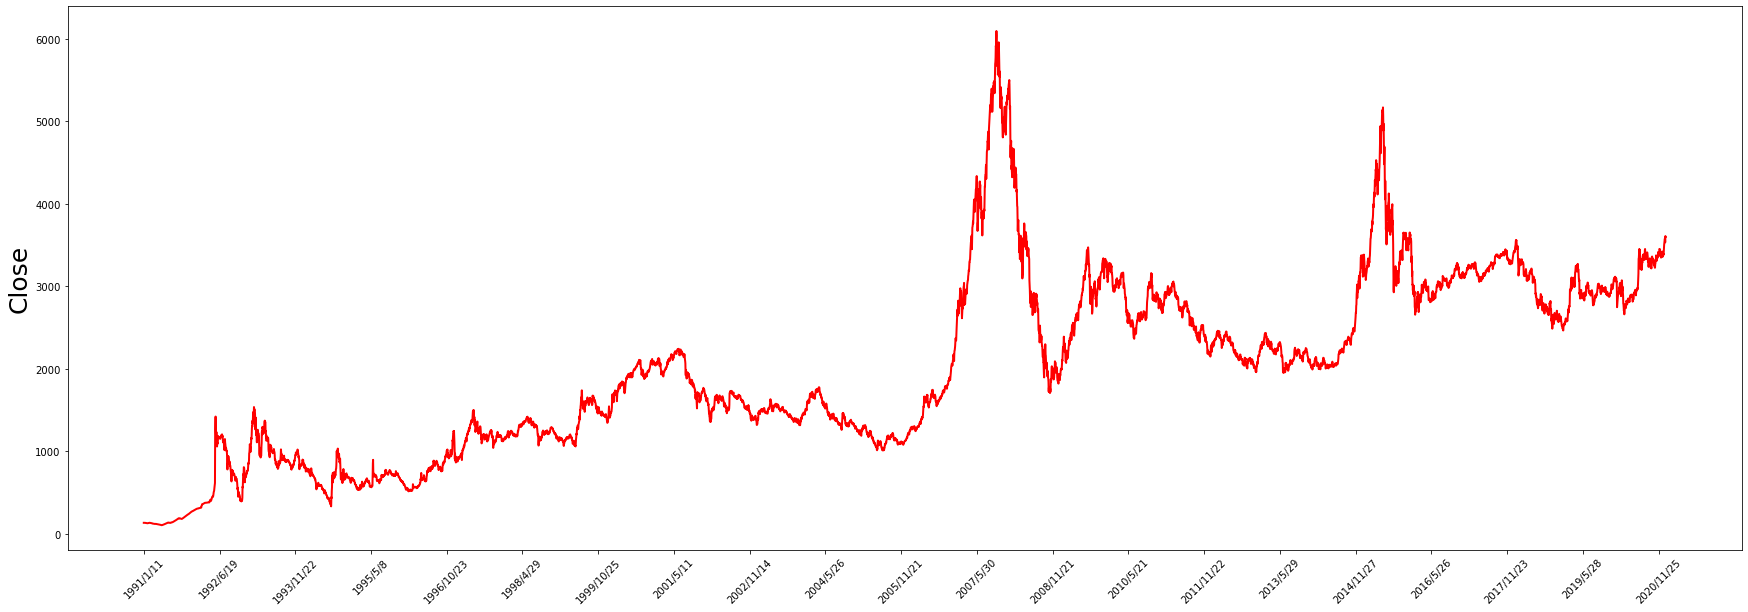

In [3]:
path = r'C:\Users\Daniel\OneDrive\桌面\data1.csv'
data = pd.read_csv(path)
close = data.iloc[:,-1]
close = np.array(close)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['figure.figsize'] = (30, 10)
plt.figure()
plt.plot(close,'r')
plt.xticks(range(0,data.shape[0],365),data['date'].loc[::365],rotation=45)
plt.ylabel('Close',fontsize=25)
plt.savefig('原始close.jpg')
plt.show()


<ipython-input-2-f422f886d9e1>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(imfs.shape[0]+1, 1, imfs.shape[0]+1)


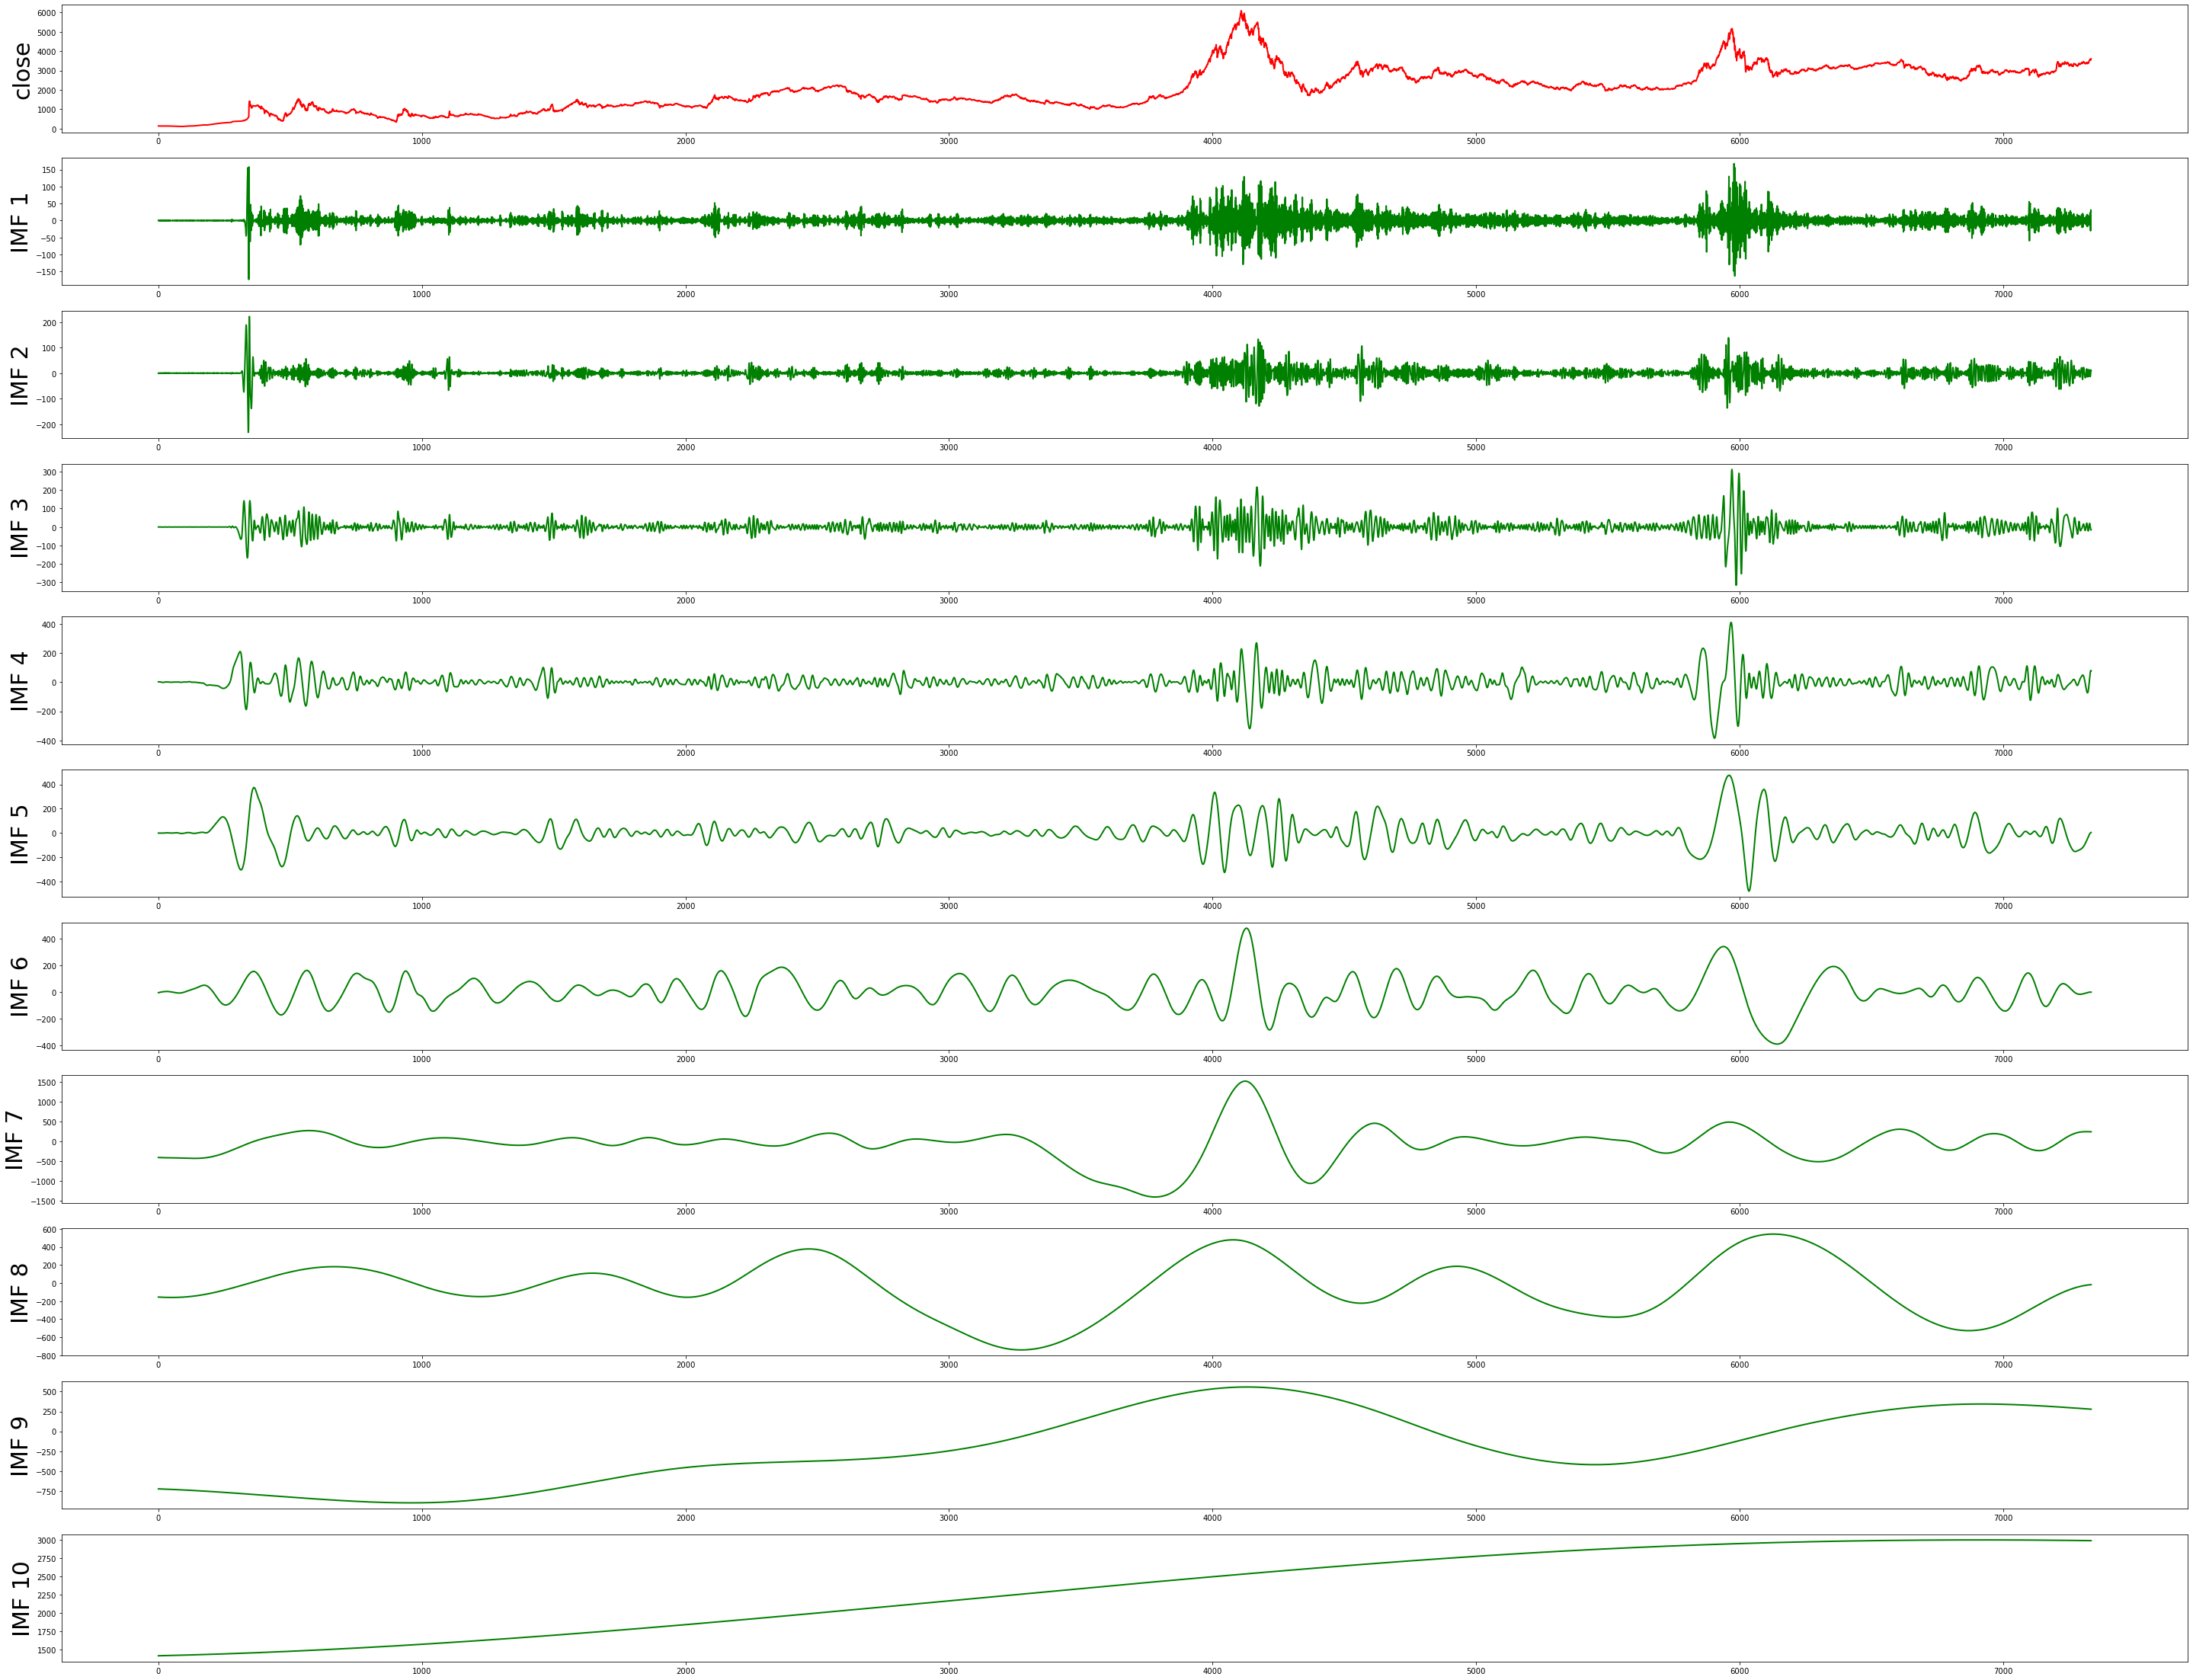

In [4]:
IImfs=[]
res=ceemdan_decompose_res(np.array(close).ravel())

In [5]:
for i in range(len(IImfs)):
# 准备数据
    data = IImfs[i].reshape(-1,1)
    data_df = pd.DataFrame(data)   #关键1，将ndarray格式转换为DataFrame

    # 更改表的索引
    data_df.columns = ['IMF'+str(i)+'s.xlsx']  

    # 将文件写入excel表格中
    writer = pd.ExcelWriter('IMF'+str(i)+'s.xlsx')  #关键2，创建名称为hhh的excel表格
    data_df.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
    writer.save()  #关键4

In [6]:
RMSE = []
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())#需要数据转化为array才能计算
for i in range(9):
    rmse_val = rmse(IImfs[i], close)
    RMSE.append(rmse_val)
    print("rms error is: " + str(rmse_val))
def normalization(data):
    _range = sum(data)
    return data/_range
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return sigma/mu
P_RMSE = normalization(RMSE)
CV_P_RMSE = standardization(P_RMSE)

rms error is: 2265.2871938798503
rms error is: 2265.2937431206833
rms error is: 2264.6149061661877
rms error is: 2265.762467360269
rms error is: 2261.4268797583304
rms error is: 2264.8438329016403
rms error is: 2288.7591606859596
rms error is: 2291.0109840546684
rms error is: 2334.395071103848


In [7]:
r = []
new_x1 = np.delete(close, 0)
new_x2 = np.delete(close, -1)
for i in range(9):
    new_imf1 = np.delete(IImfs[i], 0)
    new_imf2 = np.delete(IImfs[i],-1)
    a = sum((new_imf1-new_imf2)**2)
    r.append(a)
r = r/sum((new_x1-new_x2)**2)
P_R = normalization(r)
CV_P_R = standardization(P_R)
W_P_RMSE = CV_P_RMSE/(CV_P_RMSE + CV_P_R)
W_P_R = CV_P_R/(CV_P_RMSE + CV_P_R)
T = W_P_RMSE * P_RMSE + W_P_R * P_R
R = []
for i in range(8):
    R.append(T[i]/T[i+1])
print(R)

[3.8944458271070186, 1.5010939812232782, 2.4181260292343745, 1.751809126410245, 3.4777239215364584, 0.6801431659785243, 6.0683630527019226, 2.08493759920736]


In [8]:
W=[]

In [9]:
#模块调用
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pywt 

#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
    data = data.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('sym8')
    [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 5层小波分解

    length1 = len(cd1)
    length0 = len(data)

    Cd1 = np.array(cd1)
    abs_cd1 = np.abs(Cd1)
    median_cd1 = np.median(abs_cd1)

    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0 ), math.e))#固定阈值计算
    usecoeffs = []
    usecoeffs.append(ca5)  # 向列表末尾添加对象

    #软硬阈值折中的方法
    a = 0.9

    for k in range(length1):
        if (abs(cd1[k]) >= lamda):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
        else:
            cd1[k] = 0.0

    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
        else:
            cd2[k] = 0.0

    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
        else:
            cd3[k] = 0.0

    length4 = len(cd4)
    for k in range(length4):
        if (abs(cd4[k]) >= lamda):
            cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
        else:
            cd4[k] = 0.0

    length5 = len(cd5)
    for k in range(length5):
        if (abs(cd5[k]) >= lamda):
            cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
        else:
            cd5[k] = 0.0

    usecoeffs.append(cd5)
    usecoeffs.append(cd4)
    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)#信号重构
    return recoeffs



# for i in range(0,3):
#     data = IImfs[i]
#     data_denoising = wavelet_noising(data)
#     new_data_denoising = np.delete(data_denoising, 0)
#     IImfs[i] = new_data_denoising
    

In [10]:
for i in range(0,3):
    data = IImfs[i]
    data_denoising = wavelet_noising(data)
    new_data_denoising = np.delete(data_denoising, 0)
    IImfs[i] = new_data_denoising

In [11]:
for i in range(10):
    print(len(IImfs[i]))

7335
7335
7335
7335
7335
7335
7335
7335
7335
7335


In [12]:
len(IImfs)

10

In [13]:
for i in range(len(IImfs)):
# 准备数据
    data = IImfs[i].reshape(-1,1)
    data_df = pd.DataFrame(data)   #关键1，将ndarray格式转换为DataFrame

    # 更改表的索引
    data_df.columns = ['new_IMF'+str(i)+'s.xlsx']  

    # 将文件写入excel表格中
    writer = pd.ExcelWriter('new_IMF'+str(i)+'s.xlsx')  #关键2，创建名称为hhh的excel表格
    data_df.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
    writer.save()  #关键4

In [14]:
# for i in range(0,3):
#     EMA = 0.0
#     gamma = 0.1
#     for ti in range(len(IImfs[i])):
#         EMA = gamma*IImfs[i][ti] + (1-gamma)*EMA
#         IImfs[i][ti] = EMA

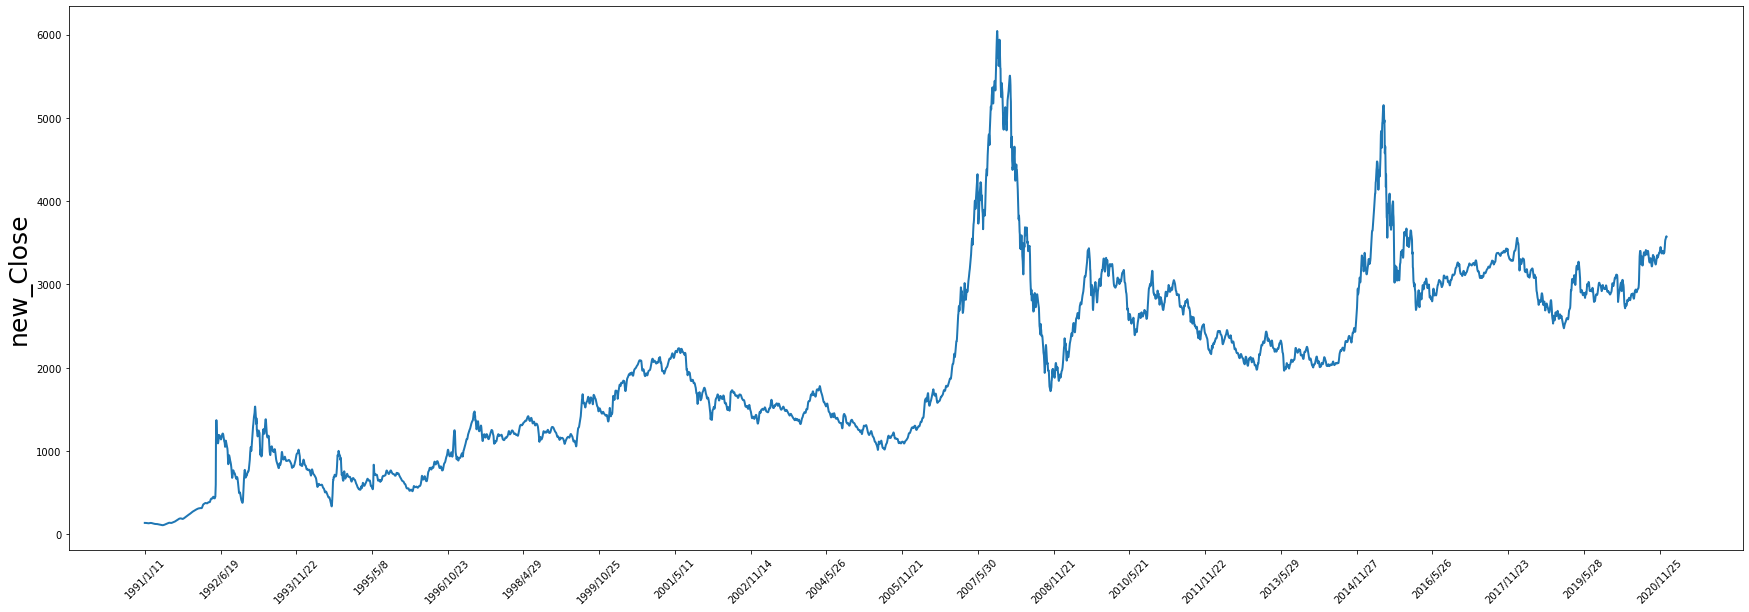

In [15]:
new_close = np.sum(IImfs, axis=0)
path = r'C:\Users\Daniel\OneDrive\桌面\data1.csv'
data = pd.read_csv(path)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['figure.figsize'] = (30, 10)
plt.figure()
plt.plot(new_close)
plt.xticks(range(0,data.shape[0],365),data['date'].loc[::365],rotation=45)
plt.ylabel('new_Close',fontsize=25)
plt.savefig('降噪后close.jpg')
plt.show()


In [16]:
# 准备数据
data = new_close.reshape(-1,1)
data_df = pd.DataFrame(data)   #关键1，将ndarray格式转换为DataFrame

# 更改表的索引
data_df.columns = ['new_close']  

# 将文件写入excel表格中
writer = pd.ExcelWriter('new_close.xlsx')  #关键2，创建名称为hhh的excel表格
data_df.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save()  #关键4

In [17]:
data

array([[ 134.39080848],
       [ 134.49876476],
       [ 134.5436385 ],
       ...,
       [3572.81774189],
       [3576.8844043 ],
       [3572.39457323]])

In [18]:
###以下为无用代码，不用运行

In [19]:
data = IImfs[1]
plt.plot(data)
plt.show()
data_denoising1\ = wavelet_noising(data)
plt.plot(data_denoising1)

SyntaxError: unexpected character after line continuation character (<ipython-input-19-148bd62c0a52>, line 4)

In [ ]:
#模块调用
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pywt 

#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
    data = data.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('bior3.5')#选择sym8小波基
    [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 5层小波分解

    length1 = len(cd1)
    length0 = len(data)

    Cd1 = np.array(cd1)
    abs_cd1 = np.abs(Cd1)
    median_cd1 = np.median(abs_cd1)

    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0 ), math.e))#固定阈值计算
    usecoeffs = []
    usecoeffs.append(ca5)  # 向列表末尾添加对象

    #软硬阈值折中的方法
    a = 0.9

    for k in range(length1):
        if (abs(cd1[k]) >= lamda):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
        else:
            cd1[k] = 0.0

    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
        else:
            cd2[k] = 0.0

    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
        else:
            cd3[k] = 0.0

    length4 = len(cd4)
    for k in range(length4):
        if (abs(cd4[k]) >= lamda):
            cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
        else:
            cd4[k] = 0.0

    length5 = len(cd5)
    for k in range(length5):
        if (abs(cd5[k]) >= lamda):
            cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
        else:
            cd5[k] = 0.0

    usecoeffs.append(cd5)
    usecoeffs.append(cd4)
    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)#信号重构
    return recoeffs


new_imf = IImfs.copy()
data = IImfs[1]
plt.plot(data)
plt.show()
data_denoising1 = wavelet_noising(data) #调用函数进行小波阈值去噪
new_imf[1] = data_denoising1
plt.plot(data_denoising1)#显示去噪结果

#data = IImfs[1]
#plt.plot(data)
#plt.show()
#data_denoising2 = wavelet_noising(data) #调用函数进行小波阈值去噪
#new_imf[1] = data_denoising2
#plt.plot(data_denoising2)#显示去噪结果


In [ ]:
#模块调用
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pywt 

#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
    data = data.T.tolist()  # 将np.ndarray()转为列表
    w = pywt.Wavelet('bior3.5')#选择sym8小波基
    [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 5层小波分解

    length1 = len(cd1)
    length0 = len(data)

    Cd1 = np.array(cd1)
    abs_cd1 = np.abs(Cd1)
    median_cd1 = np.median(abs_cd1)

    sigma = (1.0 / 0.6745) * median_cd1
    lamda = sigma * math.sqrt(2.0 * math.log(float(length0 ), math.e))#固定阈值计算
    usecoeffs = []
    usecoeffs.append(ca5)  # 向列表末尾添加对象

    #软硬阈值折中的方法
    a = 0.9

    for k in range(length1):
        if (abs(cd1[k]) >= lamda):
            cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
        else:
            cd1[k] = 0.0

    length2 = len(cd2)
    for k in range(length2):
        if (abs(cd2[k]) >= lamda):
            cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
        else:
            cd2[k] = 0.0

    length3 = len(cd3)
    for k in range(length3):
        if (abs(cd3[k]) >= lamda):
            cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
        else:
            cd3[k] = 0.0

    length4 = len(cd4)
    for k in range(length4):
        if (abs(cd4[k]) >= lamda):
            cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
        else:
            cd4[k] = 0.0

    length5 = len(cd5)
    for k in range(length5):
        if (abs(cd5[k]) >= lamda):
            cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
        else:
            cd5[k] = 0.0

    usecoeffs.append(cd5)
    usecoeffs.append(cd4)
    usecoeffs.append(cd3)
    usecoeffs.append(cd2)
    usecoeffs.append(cd1)
    recoeffs = pywt.waverec(usecoeffs, w)#信号重构
    return recoeffs


new_imf = IImfs.copy()
data = data_denoising1
plt.plot(data)
plt.show()
data_denoising1 = wavelet_noising(data) #调用函数进行小波阈值去噪
new_imf[0] = data_denoising1
plt.plot(data_denoising1)#显示去噪结果

#data = IImfs[1]
#plt.plot(data)
#plt.show()
#data_denoising2 = wavelet_noising(data) #调用函数进行小波阈值去噪
#new_imf[1] = data_denoising2
#plt.plot(data_denoising2)#显示去噪结果
